# Chain-of-Thought (CoT) Prompting
### Enhancing the Eedi dataset with some help from ChatGPT

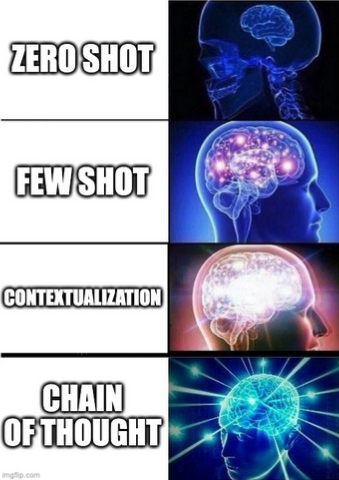

Chain-of-Thought (CoT) Prompting is the notion of presenting an LLM with examples of reasoning-through-problems as opposed to just question / answer pairs.

The idea is that by showing an LLM how to solve problems step-by-step - it might mimic those problem solving methods in its own responses (obtaining better results).

In this notebook we recruit ChatGPT to recreate the chain-of-thought thinking that human evaluators might have used to label misconceptions in the Eedi competition dataset.

This notebook outputs a complete copy of the train data augmented with the "reasoning" behind both the correct answers and each misconception.

You can use this dataset to generate your own CoT prompt sequences for inference or model training!

If you want to run this notebook yourself - you'll need to get setup with an OpenAI account / and your token to the notebook:
https://www.kaggle.com/discussions/product-feedback/114053

Stay tuned for a notebook that demonstrates actually using this data...

In [ ]:
!pip install openai
import openai
from kaggle_secrets import UserSecretsClient

# To run this you'll need to setup your own ChatGPT secret for your account
# https://www.kaggle.com/discussions/product-feedback/114053
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("OpenAI")
openai.api_key = secret_value_0

import pandas as pd
import sys
import textwrap

#if True - only runs on first 10 rows
just_quick_test = False

# ChatGPT - you there?

In [ ]:
completion = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": "Tell me about yourself."},
    ],
)

print(completion.choices[0].message.content)

# Look at Train data...

In [ ]:
train_df = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv")
train_df.head(3)

if just_quick_test:
    train_df = train_df.head(10)

# Misconception map...

In [ ]:
misc_map_df = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv")
misc_map_df.head(3)

In [ ]:
# Print things a bit prettier...

def print_formatted_conversation(messages, api_response=None):
    width = 100
    print("\nConversation:")
    print("=" * width)
    for message in messages:
        role = message['role'].capitalize()
        content = message['content']
        
        print(f"\n{role}:")
        print("-" * len(role))
        
        wrapped_content = textwrap.wrap(content, width=width)
        for line in wrapped_content:
            print(line)
        
        print()  # Add a blank line between messages
    
    if api_response:
        print("LLM Response:")
        print("-" * width)
        wrapped_response = textwrap.wrap(api_response, width=width)
        for line in wrapped_response:
            print(line)
    
    print("\n" + "=" * width + "\n")  # Final separator

# Getting some explanations
* First provide ChatGPT the question and correct answer.  Ask for explanation of the how problem could be solved correctly.
* For each wrong answer - provide the misconception.  Ask for explanation how an LLM might arrive at that misconception.
* Answers with null misconceptions are skipped
* All explanations (correct and with misconception) are saved back into new columns in DF

In [ ]:
model="gpt-4o"
misc_explain_words = 40
correct_answer_explain_words = 40
max_tokens = 150

def get_answer_explanations(df, verbose = False):

    #loop through all questions in df
    for index, row in df.iterrows():
        possible_answers = ['A', 'B', 'C', 'D']
        
        #Question text
        question = f"{row['ConstructName']}: {row['QuestionText']}"
        
        #Correct answer text
        correct_answer_letter = row.CorrectAnswer
        correct_answer_text = row[f'Answer{correct_answer_letter}Text']
    
        #start of by getting an explanation for the correct answer
        initial_question_message = {"role": "user", "content": f"{question} The correct answer is: '{correct_answer_text}', explain in {correct_answer_explain_words} words how you would solve the problem."}
       
        completion = openai.chat.completions.create(
            model=model,
            messages=[initial_question_message],
            max_tokens=max_tokens
        )
    
        response = completion.choices[0].message.content
        correct_response_explain = {"role": "assistant", "content": response}
        
        #save out explanation of correct answer to df
        df.at[index, f'Answer{correct_answer_letter}Explanation'] = response

        # cycle through all incorrect questions
        possible_answers.remove(correct_answer_letter)
        for misc_letter in possible_answers:
            misconception_id = row[f'Misconception{misc_letter}Id']
        
            #skip nans
            if not pd.isna(misconception_id):
    
                misconception_text = misc_map_df.loc[int(misconception_id), 'MisconceptionName']
                misc_answer_text = row[f'Answer{misc_letter}Text']
        
                messages = [
                    initial_question_message,   # provide original text on answer solution for context
                    correct_response_explain,
                    {"role": "user",  "content": f"A different answer provided for this question is: '{misc_answer_text}' - does that seem right to you?"},
                    {"role": "assistant", "content": "No - that is quite wrong."},  # gas-light the LLM into thinking it said something it didn't... ;)             
                    {"role": "user",  "content": (
                            f"Another LLM agreed that the answer was wrong - and concluded that the answerer had the misconception of '{misconception_text}'. "
                            "Pretend you are LLM attempting to discover what the misconception was. "
                            "Consider the question, the correct answer and incorrect answer - moving towards a conclusion about the misconception. "
                            "Your work must support the stated misconception. "
                            "Don't start with the conclusion or state the misconception - you are just working towards it. "
                            "It should seem natural the actual misconception would be the next sentence. "
                            f"Do this in {misc_explain_words} words.")}
                ]
    
                completion = openai.chat.completions.create(
                    model=model,
                    messages=messages,
                    max_tokens=max_tokens
                )
                misc_explanation = completion.choices[0].message.content

                #save misconception explanation to df
                df.at[index, f'Answer{misc_letter}Explanation'] = misc_explanation
    
                if verbose:
                    print_formatted_conversation(messages, misc_explanation)
                else:
                    print(".", end="")
    return df

quick_demo_df = train_df.tail(3).copy()
get_answer_explanations(quick_demo_df, verbose=True)

# Run on all of train

In [ ]:
augmented_train_df = get_answer_explanations(train_df, verbose=False)
augmented_train_df.head()[['QuestionText', 'CorrectAnswer', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'AnswerAExplanation', 'AnswerBExplanation', 'AnswerCExplanation', 'AnswerDExplanation']]

# Save!

In [ ]:
augmented_train_df.to_csv('augmented_train_data.csv', index=False)